## Setup

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../'))
import util
import ts_util
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timezone
from numba import njit
import pickle
import os
import sqlite3
from dotenv import load_dotenv
import strategies
load_dotenv()

True

In [3]:
reload(util)
reload(ts_util)

<module 'ts_util' from 'c:\\Users\\fujos\\Github\\Trading-Bot\\Uncon Backtest\\ts_util.py'>

In [18]:
kraken_coin_data = util.get_exchange_coins('kraken')
kraken_coin_ids = [coin['coin_id'] for coin in kraken_coin_data]
kraken_symbols = [coin['base'].lower() for coin in kraken_coin_data]
tradable_kraken_coins = util.get_tradable_kraken_coins()
# TIME IS CLOSE TIME
all_data = util.get_all_ochl()
btc_ohlc = all_data[all_data['symbol'] == 'btc'].drop(['symbol', 'coin_id', 'name'], axis=1).set_index('time_rank')
btc_ohlc[['open', 'high', 'low', 'close']] = np.log(btc_ohlc[['open', 'high', 'low', 'close']])
btc_ohlc.sort_index(inplace=True)
total_date_range = pd.date_range(start='2018-02-15 00:00:00+00:00', end=btc_ohlc.index[-1], freq='h', tz=timezone.utc)
btc_ohlc = btc_ohlc.reindex(total_date_range, method='ffill')
btc_ret = btc_ohlc['close'].diff() # if index is t, then ret[t] = close[t] - close[t-1]
in_sample_btc_ohlc = btc_ohlc.loc['2018-02-15':'2023-12-31']
out_of_sample_btc_ohlc = btc_ohlc.loc['2024-01-01':]
len(set(out_of_sample_btc_ohlc.index).difference(set(btc_ohlc.index)))+len(set(in_sample_btc_ohlc.index).difference(set(btc_ohlc.index)))  # should be empty

0

## First Look

<Axes: >

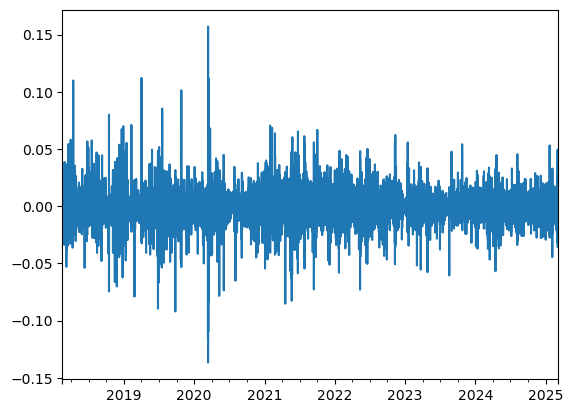

In [8]:
btc_ret.plot()

## Autocorrelation


(-0.1, 0.1)

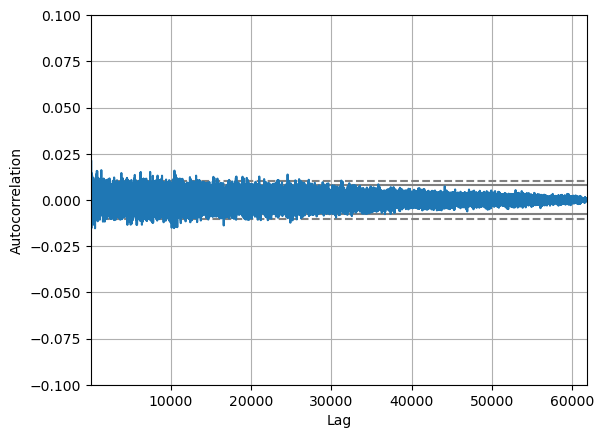

In [9]:
from pandas.plotting import autocorrelation_plot
ax = autocorrelation_plot(btc_ret.dropna())
ax.set_ylim([-.1, .1])

(-0.1, 0.1)

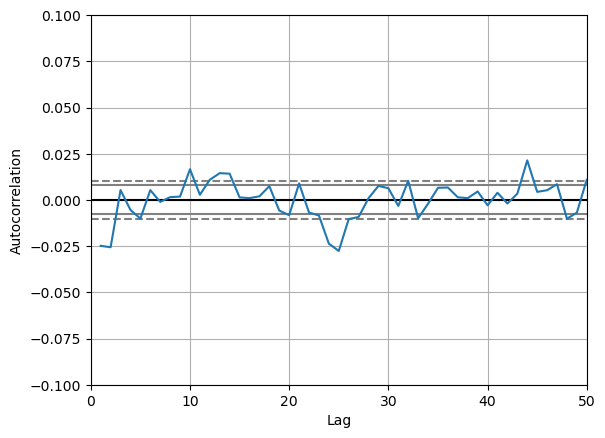

In [10]:
ax = autocorrelation_plot(btc_ret.dropna())
ax.set_xlim([0, 50])
ax.set_ylim([-.1, .1])


This means that were are free to permute series returns

## Volatility

<Axes: >

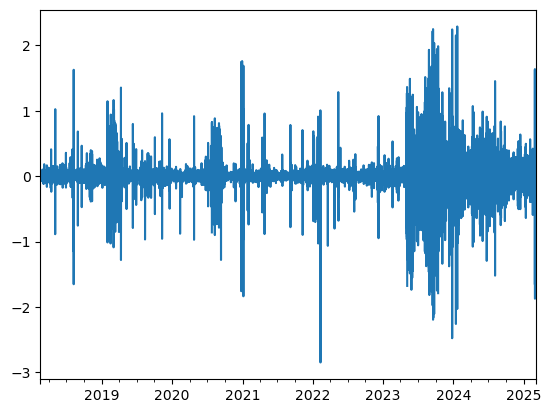

In [20]:
np.log(btc_ohlc['volume']).diff().plot()

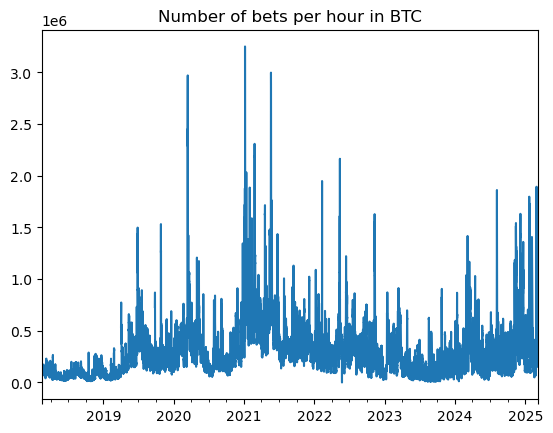

In [26]:
np.power((btc_ret.rolling(24).std()*btc_ohlc['volume']), 2/3).plot()
plt.title('Number of bets per hour in BTC')
plt.show()

c:\Users\fujos\anaconda3\envs\cakeshop\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Pct change in number of bets per hour in BTC')

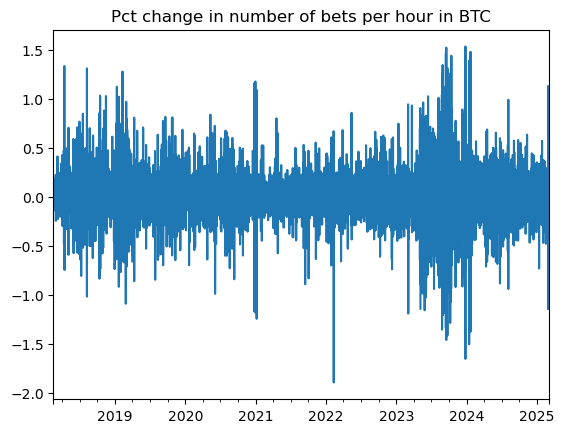

In [40]:
np.log(np.power((btc_ret.rolling(24).std()*btc_ohlc['volume']), 2/3)).diff().plot()
plt.title('Pct change in number of bets per hour in BTC')

In [48]:
reload(ts_util)
ts_util.compute_entropy(5, np.log(np.power((btc_ret.rolling(24).std()*btc_ohlc['volume']), 2/3)).diff().dropna())

0.00012178995772135617

In [49]:
ts_util.compute_entropy(10, btc_ret)

0.15795218777686162

Text(0.5, 1.0, 'Change in BTC Quantity Traded')

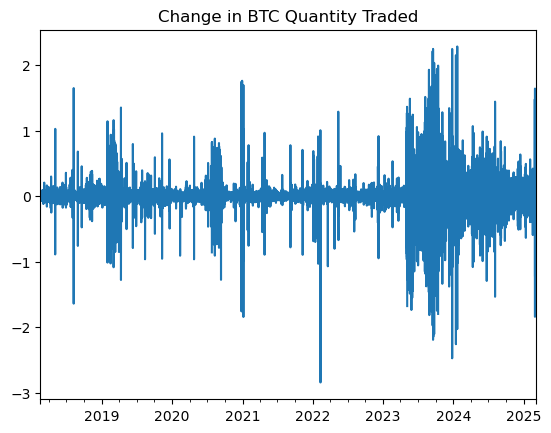

In [31]:
np.log(btc_ohlc['volume']/np.exp(btc_ohlc['close'])).diff().plot()
plt.title('Change in BTC Quantity Traded')

(-0.7, 0.1)

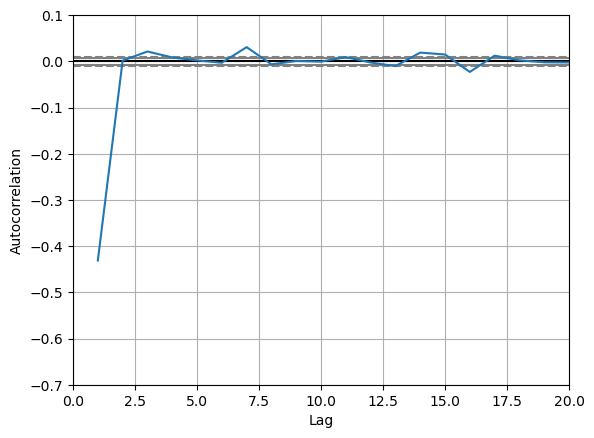

In [39]:
ax = autocorrelation_plot(np.log(btc_ohlc['volume']).diff().dropna())
ax.set_xlim([0, 20])
ax.set_ylim([-.7, .1])